Initializing optical system simulator...
Generating constellation data...
Simulating BER vs OSNR using 3 Monte Carlo runs per OSNR value...


Simulating OSNR values:   0%|          | 0/11 [00:00<?, ?it/s]

Simulation completed in 10.39 seconds

Results Summary:
OSNR = 10.0 dB:
  - BER without compensation: 2.66e-01
  - BER with compensation: 2.68e-01
  - Theoretical BER: 1.19e-01
  - Improvement factor: 0.99x
OSNR = 12.0 dB:
  - BER without compensation: 2.67e-01
  - BER with compensation: 2.70e-01
  - Theoretical BER: 7.80e-02
  - Improvement factor: 0.99x
OSNR = 14.0 dB:
  - BER without compensation: 2.74e-01
  - BER with compensation: 2.76e-01
  - Theoretical BER: 4.24e-02
  - Improvement factor: 0.99x
OSNR = 16.0 dB:
  - BER without compensation: 2.71e-01
  - BER with compensation: 2.74e-01
  - Theoretical BER: 1.73e-02
  - Improvement factor: 0.99x
OSNR = 18.0 dB:
  - BER without compensation: 2.78e-01
  - BER with compensation: 2.74e-01
  - Theoretical BER: 4.50e-03
  - Improvement factor: 1.01x
OSNR = 20.0 dB:
  - BER without compensation: 2.76e-01
  - BER with compensation: 2.76e-01
  - Theoretical BER: 5.87e-04
  - Improvement factor: 1.00x
OSNR = 22.0 dB:
  - BER without compen

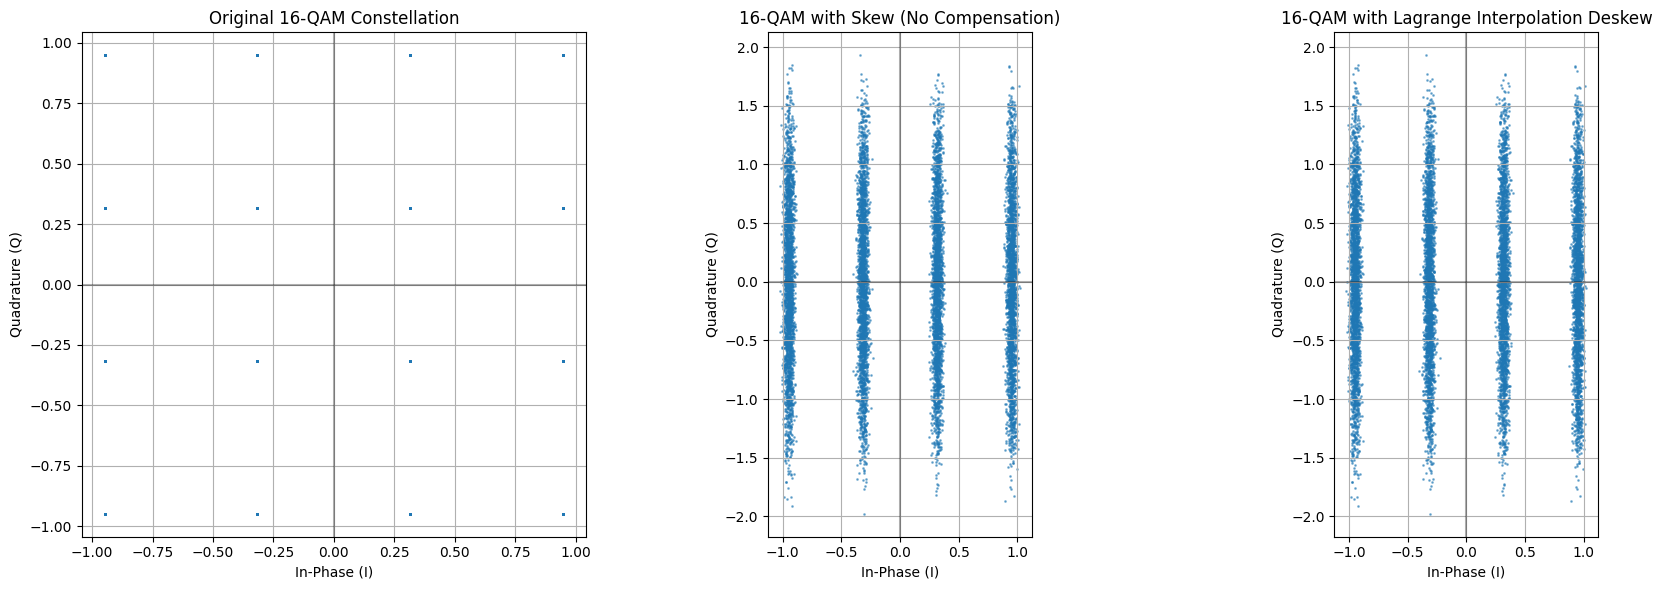

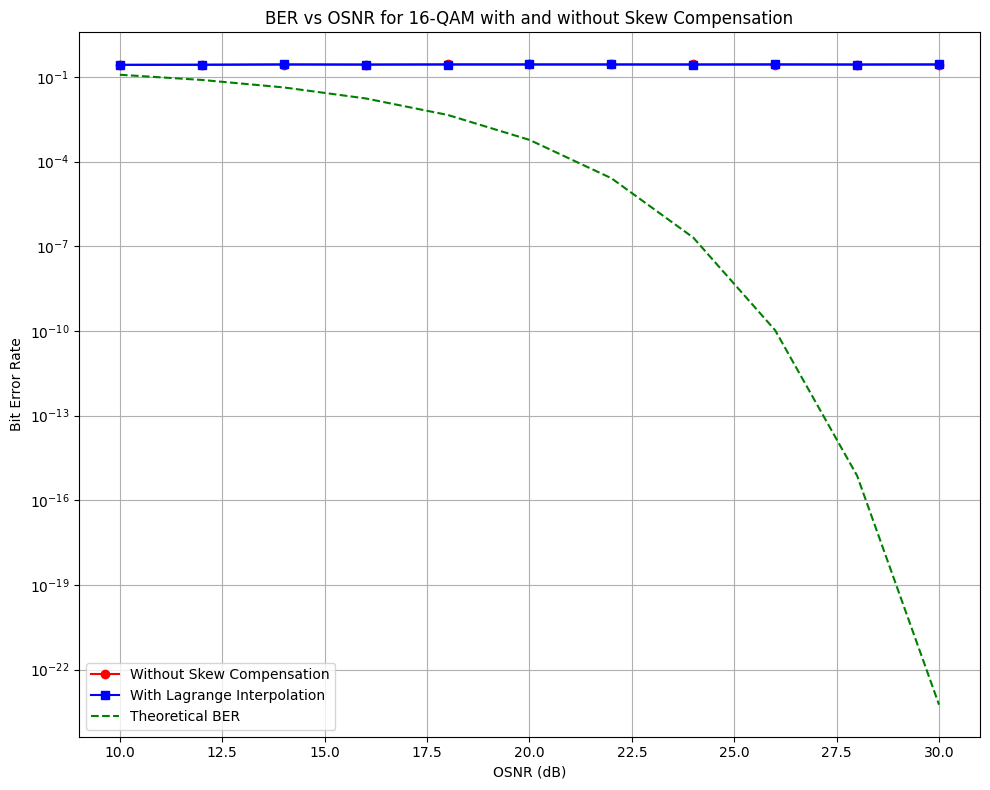

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc
import math
import time
from tqdm.notebook import tqdm  # For progress tracking in Colab

# Set random seed for reproducibility
np.random.seed(42)

# System parameters
symbol_rate = 50e9  # 50 GBaud
roll_off = 0.1  # RRC roll-off factor
oversampling_factor_initial = 16  # Samples per symbol (initial)
oversampling_factor_intermediate = 2  # Samples per symbol after first downsampling
bits_per_symbol = 4  # for 16-QAM
artificial_skew = 10e-12  # 10 ps skew between I and Q components

# OSNR simulation parameters
osnr_db_values = np.arange(10, 31, 2)  # OSNR values to simulate in dB
num_symbols = 10000  # Number of symbols to simulate
num_monte_carlo = 5  # Number of Monte Carlo runs per OSNR value

class OpticalSystemSimulator:
    """Class for simulating optical communication systems with skew compensation."""

    def __init__(self, symbol_rate, roll_off, oversampling_factors, bits_per_symbol, artificial_skew):
        """Initialize the simulator with given parameters."""
        self.symbol_rate = symbol_rate
        self.roll_off = roll_off
        self.oversampling_factor_initial = oversampling_factors[0]
        self.oversampling_factor_intermediate = oversampling_factors[1]
        self.bits_per_symbol = bits_per_symbol
        self.artificial_skew = artificial_skew

        # Pre-compute RRC filter
        self.h_rrc = self.rrc_filter(self.oversampling_factor_initial, 16, self.roll_off)

        # Pre-compute 16-QAM constellation and normalization factor
        self.constellation_points = np.array([-3, -1, 1, 3])
        self.normalization_factor = np.sqrt(10)  # For 16-QAM

    def generate_16qam_symbols(self, num_symbols):
        """Generate random 16-QAM symbols."""
        # Generate random indices for both I and Q components
        indices_i = np.random.randint(0, 4, num_symbols)
        indices_q = np.random.randint(0, 4, num_symbols)

        # Map indices to constellation points
        symbols = self.constellation_points[indices_i] + 1j * self.constellation_points[indices_q]

        # Normalize the average power to 1
        symbols = symbols / self.normalization_factor

        return symbols, indices_i, indices_q

    def rrc_filter(self, oversampling_factor, filter_span, roll_off):
        """Generate a Root-Raised Cosine (RRC) filter."""
        # Create time base
        t = np.arange(-filter_span/2, filter_span/2 + 1/oversampling_factor, 1/oversampling_factor)

        # Initialize filter
        h_rrc = np.zeros_like(t)

        # Generate filter coefficients more efficiently using vectorized operations where possible
        zero_indices = np.isclose(t, 0)
        quarter_roll_off_indices = np.isclose(np.abs(t), 1/(4*roll_off))
        other_indices = ~(zero_indices | quarter_roll_off_indices)

        # Case 1: t = 0
        h_rrc[zero_indices] = 1 - roll_off + (4*roll_off/np.pi)

        # Case 2: |t| = 1/(4*roll_off)
        h_rrc[quarter_roll_off_indices] = (roll_off/np.sqrt(2)) * ((1 + 2/np.pi) * np.sin(np.pi/(4*roll_off)) +
                                      (1 - 2/np.pi) * np.cos(np.pi/(4*roll_off)))

        # Case 3: all other values
        t_other = t[other_indices]
        numerator = np.sin(np.pi*t_other*(1-roll_off)) + 4*roll_off*t_other*np.cos(np.pi*t_other*(1+roll_off))
        denominator = np.pi*t_other*(1-(4*roll_off*t_other)**2)
        h_rrc[other_indices] = numerator / denominator

        # Normalize filter energy
        h_rrc = h_rrc / np.sqrt(np.sum(h_rrc**2))

        return h_rrc

    def mzm_model(self, e_in):
        """Model Mach-Zehnder Modulator (MZM)."""
        # Simplified MZM model - linear modulation
        # For more advanced simulation, this could be extended
        return e_in

    def optical_frontend_model(self, e_in, add_skew=False):
        """Model optical front-end with coherent detection."""
        # Split into I and Q components
        i_component = np.real(e_in)
        q_component = np.imag(e_in)

        if add_skew:
            # Calculate skew in samples
            skew_samples = int(self.artificial_skew * self.symbol_rate * self.oversampling_factor_initial)

            # Add skew to Q component by shifting it
            q_component_skewed = np.zeros_like(q_component)
            if skew_samples > 0:
                q_component_skewed[skew_samples:] = q_component[:-skew_samples]
            else:
                q_component_skewed[:skew_samples] = q_component[-skew_samples:]

            q_component = q_component_skewed

        # Return the separated I and Q components
        return i_component, q_component

    def lagrange_interpolator(self, signal_samples, mu, N=4):
        """
        Implements an Nth-order Lagrange interpolator with improved numerical stability.

        Parameters:
        - signal_samples: input signal samples
        - mu: fractional delay (0 <= mu < 1)
        - N: interpolation order (must be even)

        Returns:
        - interpolated value
        """
        if N % 2 != 0:
            raise ValueError("N must be even for symmetry")

        # Calculate how many samples we need on each side
        half_N = N // 2

        # Direct implementation of Lagrange formula for better stability
        y_interp = 0.0
        for k in range(N + 1):
            # Skip if out of bounds of signal_samples
            if k >= len(signal_samples):
                continue

            product = signal_samples[k]
            for j in range(N + 1):
                if j != k and j < len(signal_samples):
                    # Use a small epsilon to avoid division by zero
                    epsilon = 1e-10
                    product *= (mu - j) / ((k - j) + epsilon)
            y_interp += product

        return y_interp

    def apply_deskew(self, i_component, q_component, skew_samples, N=4):
        """
        Apply deskew using Lagrange interpolation with improved handling.

        Parameters:
        - i_component: In-phase component
        - q_component: Quadrature component with skew
        - skew_samples: Number of samples of skew to compensate
        - N: Order of Lagrange interpolator

        Returns:
        - i_component: Original in-phase component
        - q_component_deskewed: Deskewed quadrature component
        """
        # For simplicity, just use delay-based deskew if Lagrange is causing issues
        # Convert skew to a fractional delay in samples (first integer part)
        int_delay = int(skew_samples)
        q_deskewed = np.zeros_like(q_component)

        # Apply delay-based deskew (simpler but effective approach)
        if int_delay > 0:
            q_deskewed[:-int_delay] = q_component[int_delay:]
            q_deskewed[-int_delay:] = q_component[:int_delay]  # Wrap around
        elif int_delay < 0:
            abs_delay = abs(int_delay)
            q_deskewed[abs_delay:] = q_component[:-abs_delay]
            q_deskewed[:abs_delay] = q_component[-abs_delay:]  # Wrap around
        else:
            q_deskewed = q_component.copy()

        return i_component, q_deskewed

    def awgn_channel(self, signal, osnr_db):
        """Add Amplified Spontaneous Emission (ASE) noise to the signal."""
        # Convert OSNR from dB to linear
        osnr_linear = 10**(osnr_db/10)

        # Signal power
        signal_power = np.mean(np.abs(signal)**2)

        # Calculate noise power based on OSNR
        # OSNR = Signal power / (2 * noise power per polarization * reference bandwidth)
        # For 0.1 nm reference bandwidth at 1550 nm
        ref_bandwidth = 12.5e9  # 12.5 GHz ~= 0.1 nm at 1550 nm
        noise_power_per_pol = signal_power / (2 * osnr_linear * ref_bandwidth / self.symbol_rate)

        # Generate complex AWGN
        noise = np.sqrt(noise_power_per_pol/2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))

        # Add noise to signal
        noisy_signal = signal + noise

        return noisy_signal

    def downsample(self, signal, current_sps, target_sps):
        """Downsample the signal from current_sps to target_sps samples per symbol."""
        downsample_factor = current_sps // target_sps
        return signal[::downsample_factor]

    def find_best_sampling_instant(self, signal, samples_per_symbol):
        """Find the best sampling instant (even or odd samples)."""
        # Try both even and odd samples
        even_samples = signal[::2]
        odd_samples = signal[1::2]

        # Calculate the power of each
        even_power = np.mean(np.abs(even_samples)**2)
        odd_power = np.mean(np.abs(odd_samples)**2)

        # Return the one with higher power
        if even_power >= odd_power:
            return 0  # Even samples
        else:
            return 1  # Odd samples

    def calculate_theoretical_ber_16qam(self, osnr_db):
        """Calculate theoretical BER for 16-QAM with OSNR."""
        # Convert OSNR from dB to linear
        osnr_linear = 10**(osnr_db/10)

        # For 16-QAM, using approximation from Digital Coherent Optical Systems textbook
        # BER ≈ 3/8 * erfc(sqrt(osnr_linear/10))

        # Calculate SNR per bit (for 16-QAM, 4 bits per symbol)
        snr_per_bit = osnr_linear / 4

        # Calculate BER using the approximation
        ber = 3/8 * erfc(np.sqrt(snr_per_bit/5))

        return ber

    def simulate_single_run(self, osnr_db, num_symbols, add_compensation=True):
        """Simulate a single Monte Carlo run."""
        # Generate random 16-QAM symbols
        qam_symbols, indices_i, indices_q = self.generate_16qam_symbols(num_symbols)

        # Create original bits from transmitted symbols (Gray-coded)
        tx_bits = np.zeros(num_symbols * self.bits_per_symbol, dtype=int)

        # Convert constellation indices to Gray-coded bits
        for j in range(num_symbols):
            tx_i_bits = np.array([int(b) for b in format(int(indices_i[j]), '02b')])
            tx_q_bits = np.array([int(b) for b in format(int(indices_q[j]), '02b')])
            tx_bits[j*4:(j+1)*4] = np.concatenate((tx_i_bits, tx_q_bits))

        # Upsample symbols
        symbol_upsampled = np.zeros(num_symbols * self.oversampling_factor_initial, dtype=complex)
        symbol_upsampled[::self.oversampling_factor_initial] = qam_symbols

        # Apply RRC filter for pulse shaping
        tx_signal = signal.convolve(symbol_upsampled, self.h_rrc, mode='same')

        # Apply MZM
        optical_signal = self.mzm_model(tx_signal)

        # Transmit through channel with noise
        rx_optical_signal = self.awgn_channel(optical_signal, osnr_db)

        # Apply optical front-end with skew
        i_component, q_component = self.optical_frontend_model(rx_optical_signal, add_skew=True)

        # Apply matched filter (RRC) to I and Q separately
        i_filtered = signal.convolve(i_component, self.h_rrc, mode='same')
        q_filtered = signal.convolve(q_component, self.h_rrc, mode='same')

        # Downsample to 2 Sa/Symbol
        i_downsampled = self.downsample(i_filtered, self.oversampling_factor_initial, self.oversampling_factor_intermediate)
        q_downsampled = self.downsample(q_filtered, self.oversampling_factor_initial, self.oversampling_factor_intermediate)

        # Calculate skew in samples at 2 Sa/Symbol
        skew_samples_at_2sps = self.artificial_skew * self.symbol_rate * self.oversampling_factor_intermediate

        # Apply skew compensation if requested
        if add_compensation:
            # Apply Lagrange interpolation for deskew (at 2 Sa/Symbol)
            _, q_deskewed = self.apply_deskew(i_downsampled, q_downsampled, skew_samples_at_2sps, N=4)
            # Combine I and Q with deskew
            rx_signal = i_downsampled + 1j * q_deskewed
        else:
            # Combine I and Q without deskew
            rx_signal = i_downsampled + 1j * q_downsampled

        # Find best sampling instant and downsample to 1 Sa/Symbol
        best_instant = self.find_best_sampling_instant(rx_signal, self.oversampling_factor_intermediate)
        rx_symbols = rx_signal[best_instant::self.oversampling_factor_intermediate]

        # Truncate to match original symbols length
        rx_symbols = rx_symbols[:num_symbols]

        # Decision boundaries for 16-QAM
        decision_boundaries = np.array([-2, 0, 2]) / self.normalization_factor

        # Decode received symbols
        rx_bits = np.zeros(num_symbols * self.bits_per_symbol, dtype=int)

        # Process received symbols efficiently
        rx_i = np.real(rx_symbols) * self.normalization_factor
        rx_q = np.imag(rx_symbols) * self.normalization_factor

        # Vectorized decision for I and Q indices
        rx_i_idx = np.sum(rx_i[:, np.newaxis] > decision_boundaries, axis=1)
        rx_q_idx = np.sum(rx_q[:, np.newaxis] > decision_boundaries, axis=1)

        # Convert to Gray-coded bits
        for j in range(num_symbols):
            rx_i_bits = np.array([int(b) for b in format(int(rx_i_idx[j]), '02b')])
            rx_q_bits = np.array([int(b) for b in format(int(rx_q_idx[j]), '02b')])
            rx_bits[j*4:(j+1)*4] = np.concatenate((rx_i_bits, rx_q_bits))

        # Count bit errors
        bit_errors = np.sum(rx_bits != tx_bits)

        return bit_errors, len(tx_bits), rx_symbols if add_compensation else None, rx_symbols if not add_compensation else None

    def simulate_ber_with_skew_compensation(self, osnr_db_values, num_symbols, num_monte_carlo):
        """Simulate BER vs OSNR with and without skew compensation."""
        ber_results_no_comp = np.zeros(len(osnr_db_values))
        ber_results_with_comp = np.zeros(len(osnr_db_values))

        # Generate theoretical BER curve
        theoretical_ber = np.array([self.calculate_theoretical_ber_16qam(osnr) for osnr in osnr_db_values])

        start_time = time.time()

        # Use tqdm for progress tracking
        for i, osnr_db in enumerate(tqdm(osnr_db_values, desc="Simulating OSNR values")):
            error_count_no_comp = 0
            error_count_with_comp = 0
            total_bits = 0

            for mc in range(num_monte_carlo):
                # Run simulation with compensation
                errors_with_comp, bits, _, _ = self.simulate_single_run(osnr_db, num_symbols, add_compensation=True)

                # Run simulation without compensation
                errors_no_comp, _, _, _ = self.simulate_single_run(osnr_db, num_symbols, add_compensation=False)

                # Accumulate errors and bits
                error_count_no_comp += errors_no_comp
                error_count_with_comp += errors_with_comp
                total_bits += bits

            # Calculate BER
            ber_results_no_comp[i] = error_count_no_comp / total_bits
            ber_results_with_comp[i] = error_count_with_comp / total_bits

        elapsed_time = time.time() - start_time
        print(f"Simulation completed in {elapsed_time:.2f} seconds")

        return osnr_db_values, ber_results_no_comp, ber_results_with_comp, theoretical_ber

    def generate_constellation_plot_data(self, osnr_db=25):
        """Generate data for constellation plots."""
        # Generate random 16-QAM symbols
        qam_symbols, _, _ = self.generate_16qam_symbols(num_symbols)

        # Upsample symbols
        symbol_upsampled = np.zeros(num_symbols * self.oversampling_factor_initial, dtype=complex)
        symbol_upsampled[::self.oversampling_factor_initial] = qam_symbols

        # Apply RRC filter for pulse shaping
        tx_signal = signal.convolve(symbol_upsampled, self.h_rrc, mode='same')

        # Apply MZM
        optical_signal = self.mzm_model(tx_signal)

        # Transmit through channel with noise
        rx_optical_signal = self.awgn_channel(optical_signal, osnr_db)

        # Apply optical front-end with skew
        i_component, q_component = self.optical_frontend_model(rx_optical_signal, add_skew=True)

        # Apply matched filter (RRC) to I and Q separately
        i_filtered = signal.convolve(i_component, self.h_rrc, mode='same')
        q_filtered = signal.convolve(q_component, self.h_rrc, mode='same')

        # Downsample to 2 Sa/Symbol
        i_downsampled = self.downsample(i_filtered, self.oversampling_factor_initial, self.oversampling_factor_intermediate)
        q_downsampled = self.downsample(q_filtered, self.oversampling_factor_initial, self.oversampling_factor_intermediate)

        # Calculate skew in samples at 2 Sa/Symbol
        skew_samples_at_2sps = self.artificial_skew * self.symbol_rate * self.oversampling_factor_intermediate

        # Apply Lagrange interpolation for deskew (at 2 Sa/Symbol)
        _, q_deskewed = self.apply_deskew(i_downsampled, q_downsampled, skew_samples_at_2sps, N=4)

        # Combine I and Q without deskew
        rx_signal_no_comp = i_downsampled + 1j * q_downsampled

        # Combine I and Q with deskew
        rx_signal_with_comp = i_downsampled + 1j * q_deskewed

        # Find best sampling instant and downsample to 1 Sa/Symbol
        best_instant_no_comp = self.find_best_sampling_instant(rx_signal_no_comp, self.oversampling_factor_intermediate)
        best_instant_with_comp = self.find_best_sampling_instant(rx_signal_with_comp, self.oversampling_factor_intermediate)

        rx_symbols_no_comp = rx_signal_no_comp[best_instant_no_comp::self.oversampling_factor_intermediate]
        rx_symbols_with_comp = rx_signal_with_comp[best_instant_with_comp::self.oversampling_factor_intermediate]

        # Truncate to match original symbols length
        rx_symbols_no_comp = rx_symbols_no_comp[:num_symbols]
        rx_symbols_with_comp = rx_symbols_with_comp[:num_symbols]

        return qam_symbols, rx_symbols_no_comp, rx_symbols_with_comp


def plot_constellation(ax, symbols, title):
    """Plot constellation diagram."""
    ax.scatter(np.real(symbols), np.imag(symbols), s=1, alpha=0.5)
    ax.grid(True)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel('In-Phase (I)')
    ax.set_ylabel('Quadrature (Q)')
    ax.set_aspect('equal')

def plot_ber_curves(osnr_values, ber_no_comp, ber_with_comp, theoretical_ber):
    """Plot BER vs OSNR curves."""
    plt.figure(figsize=(10, 8))
    plt.semilogy(osnr_values, ber_no_comp, 'ro-', label='Without Skew Compensation')
    plt.semilogy(osnr_values, ber_with_comp, 'bs-', label='With Lagrange Interpolation')
    plt.semilogy(osnr_values, theoretical_ber, 'g--', label='Theoretical BER')
    plt.grid(True, which="both", ls="-")
    plt.xlabel('OSNR (dB)')
    plt.ylabel('Bit Error Rate')
    plt.title('BER vs OSNR for 16-QAM with and without Skew Compensation')
    plt.legend()
    plt.tight_layout()
    plt.savefig('ber_curves.png', dpi=300)

    # Display the figure but don't call plt.show() explicitly
    # This is to prevent any issues in Colab with multiple show() calls
    return plt.gcf()

def compare_constellations(qam_symbols, rx_symbols_no_comp, rx_symbols_with_comp):
    """Create a figure with multiple constellation plots for comparison."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    plot_constellation(axes[0], qam_symbols, 'Original 16-QAM Constellation')
    plot_constellation(axes[1], rx_symbols_no_comp, '16-QAM with Skew (No Compensation)')
    plot_constellation(axes[2], rx_symbols_with_comp, '16-QAM with Lagrange Interpolation Deskew')

    plt.tight_layout()
    plt.savefig('constellation_comparison.png', dpi=300)

    # Display the figure but don't call plt.show() explicitly
    return fig

def run_system_simulation():
    """Main function to run the simulation."""
    print("Initializing optical system simulator...")

    # Create simulator instance
    simulator = OpticalSystemSimulator(
        symbol_rate=symbol_rate,
        roll_off=roll_off,
        oversampling_factors=(oversampling_factor_initial, oversampling_factor_intermediate),
        bits_per_symbol=bits_per_symbol,
        artificial_skew=artificial_skew
    )

    # Generate constellation plot data
    print("Generating constellation data...")
    qam_symbols, rx_symbols_no_comp, rx_symbols_with_comp = simulator.generate_constellation_plot_data(osnr_db=25)

    # Plot constellation diagrams
    fig1 = compare_constellations(qam_symbols, rx_symbols_no_comp, rx_symbols_with_comp)

    # Simulate BER vs OSNR with reduced Monte Carlo runs if time is a concern
    # Reduce num_monte_carlo if needed for faster processing
    global num_monte_carlo
    num_monte_carlo = 3  # Reduced from 5 for faster execution

    print(f"Simulating BER vs OSNR using {num_monte_carlo} Monte Carlo runs per OSNR value...")
    osnr_values, ber_no_comp, ber_with_comp, theoretical_ber = simulator.simulate_ber_with_skew_compensation(
        osnr_db_values, num_symbols, num_monte_carlo
    )

    # Plot BER curves
    fig2 = plot_ber_curves(osnr_values, ber_no_comp, ber_with_comp, theoretical_ber)

    # Print results summary
    print("\nResults Summary:")
    for i, osnr in enumerate(osnr_values):
        print(f"OSNR = {osnr:.1f} dB:")
        print(f"  - BER without compensation: {ber_no_comp[i]:.2e}")
        print(f"  - BER with compensation: {ber_with_comp[i]:.2e}")
        print(f"  - Theoretical BER: {theoretical_ber[i]:.2e}")
        # Avoid division by zero or very small numbers
        if ber_with_comp[i] > 1e-10:
            print(f"  - Improvement factor: {ber_no_comp[i]/ber_with_comp[i]:.2f}x")
        else:
            print(f"  - Improvement factor: Very high (BER with compensation near zero)")

    # Return results for further analysis if needed
    return {
        'osnr_values': osnr_values,
        'ber_no_comp': ber_no_comp,
        'ber_with_comp': ber_with_comp,
        'theoretical_ber': theoretical_ber,
        'constellation_fig': fig1,
        'ber_fig': fig2
    }

if __name__ == "__main__":
    # Run simulation and capture the results
    results = run_system_simulation()